# Small World Graphs

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

# from utils import decorate, savefig

# I set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

# TODO: remove this when NetworkX is fixed
from warnings import simplefilter
import matplotlib.cbook
simplefilter("ignore", matplotlib.cbook.mplDeprecation)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    In addition, you can use `legend=False` to suppress the legend.
    And you can use `loc` to indicate the location of the legend
    (the default value is 'best')
    """
    loc = options.pop("loc", "best")
    if options.pop("legend", True):
        legend(loc=loc)

    plt.gca().set(**options)
    plt.tight_layout()


def savefig(*args, **kwargs):
    print("SAVEFIG ROUTINE.")

In [ ]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [ ]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [ ]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [ ]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [ ]:
lattice = make_ring_lattice(10, 4)

SAVEFIG ROUTINE.


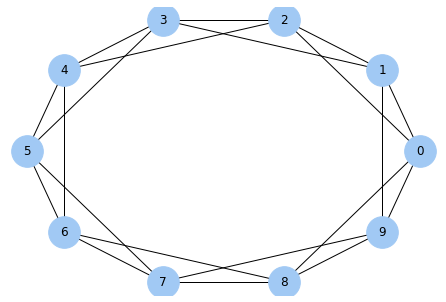

In [ ]:
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

savefig('figs/chap03-1')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=3` or `k=5`.

## WS graph

To make a WS graph, you start with a ring lattice and then rewire.

In [ ]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [ ]:
def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

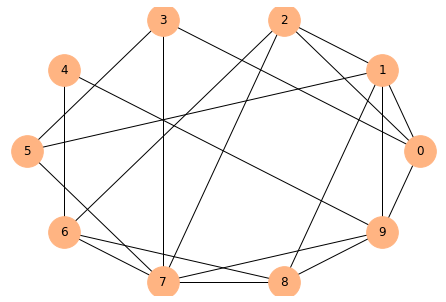

In [ ]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color='C1', 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [ ]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

SAVEFIG ROUTINE.


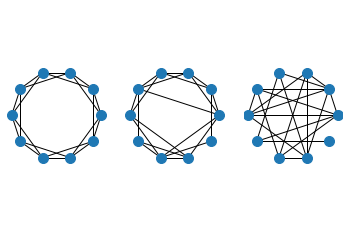

In [ ]:
n = 10
k = 4
ns = 100

plt.subplot(1,3,1)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

#TODO: Set figure size
savefig('figs/chap03-2')

**Exercise:** What is the order of growth of `rewire`?

##### Solution:
For a ring lattice $G$ of order $k$, all nodes in $G$ have $k$ adjacent nodes. The number of edges in $G$ is then $n(k/2)$ where $n$ is the number of nodes in $G$.

If we pass a ring lattice (say $G$) to the `rewire` routine with a probability of $p = 1.0$, all edges are rewired. So the order of growth for the `rewrite` routine is $O(nk/2 + C)$ -> $O(nk)$ where $C$ is some constant overhead.

But if $p$ is less than 1.0, on average `rewire` would rewire $pnk$ number of edges. The order of growth on average then is $O(pnk)$.

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [ ]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [ ]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [ ]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [ ]:
clustering_coefficient(lattice)

0.5

Correct.

In [ ]:
%timeit clustering_coefficient(lattice)

The slowest run took 7.12 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 118 µs per loop


**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.  Is it faster?

In [ ]:
# SOLUTION:
def node_clustering_2(G, u):
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
    
    possible = k * (k-1) / 2
    with_edges = [1 for v, w in all_pairs(neighbors) if G.has_edge(v, w)]
    return len(with_edges) / possible


def clustering_coefficient_2(G):
    cu = [node_clustering_2(G, node) for node in G]
    return np.nanmean(cu)

In [ ]:
%timeit clustering_coefficient(lattice)
%timeit clustering_coefficient_2(lattice)

10000 loops, best of 3: 119 µs per loop
10000 loops, best of 3: 123 µs per loop


**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

##### **Solution:**
NOTE: $n$: number of nodes. $m$: number of edges. $k$: order.

Given $k$ number of nodes, the number of possible undirected edges between each of them is $k(k-1)/2$. So, the `for` loop in function `node_clustering` will loop $k_u(k_u-1)/2$ times where $k_u$ is the number of neighbors the node `u` has. For now, we suppose that the `len` function runs in constant time. For all we know, the length of `neighbors` might already be calculated at the time the graph `G` is initialized and stored as a hidden attribute. In addition to the number of loops in `node_clustering`, the `exist += 1` statement is executed $m_u$ times where $m_u$ is the actual number of edges in the current cluster, i.e. the set of nodes neighboring the current node `u`.

`TODO: Add more explanations`

Noting that `clustering_coefficient` calls `node_clustering` for each nodes in the undirected graph $G$, the order then is $O(nk^2 + m)$

## Path length

The following function computes path lengths between all pairs of nodes

In [ ]:
def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            yield dist

The characteristic path length is the mean path length for all pairs.

In [ ]:
def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

On a complete graph, the average path length should be 1

In [ ]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)

0.9

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [ ]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.4

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [ ]:
# Solution goes here
lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)

1.5

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [ ]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes a few seconds on my computer:

In [ ]:
%time run_one_graph(1000, 10, 0.01)

8.278628 0.6443376623376623
CPU times: user 1.77 s, sys: 3.8 ms, total: 1.77 s
Wall time: 1.78 s


(8.278628, 0.6443376623376623)

Now we'll run it with a range of values for `p`.

In [ ]:
ps = np.logspace(-4, 0, 9)
print(ps)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [ ]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns:
    """
    res = []
    for p in ps:
        print(p)
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        print(means)
        res.append(means)
    return np.array(res)

Here are the raw results.  Warning: this takes a few minutes to run.

In [ ]:
# %time res = run_experiment(ps)

In [ ]:
# res

Let's get the results into a form that's easy to plot.

In [ ]:
# L, C = np.transpose(res)

In [ ]:
# L

In [ ]:
# C

And normalize them so they both start at 1.0

In [ ]:
# L /= L[0]
# C /= C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

In [ ]:
# plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
# plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
# decorate(xlabel='Rewiring probability (p)', xscale='log',
#          title='Normalized clustering coefficient and path length',
#          xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

# savefig('figs/chap03-3')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [ ]:
lattice = make_ring_lattice(10, 4)

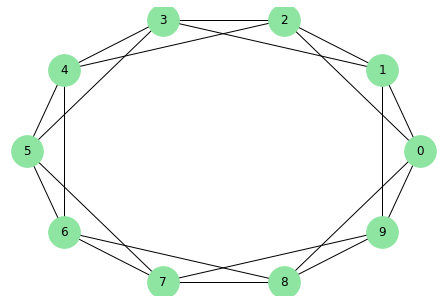

In [ ]:
nx.draw_circular(lattice, 
                 node_color='C2', 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [ ]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [ ]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [ ]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) - seen
            queue.extend(neighbors)
    return seen

It works, too.

In [ ]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [ ]:
def shortest_path_dijkstra(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [ ]:
lattice = make_ring_lattice(10, 4)

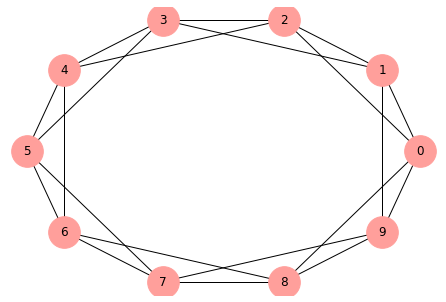

In [ ]:
nx.draw_circular(lattice, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [ ]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

And here's the result from NetworkX:

In [ ]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

They are the same:

In [ ]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [ ]:
# Solution goes here

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [ ]:
# SOLUTION:
from math import ceil


def make_regular_graph(n, k):
    nodes = range(n)
    edges = get_regular_edges(nodes, k)
    if k > 0 and len(edges) == 0:
        raise ValueError(f"Cannot make a {k}-regular graph with {n} node(s)")

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    nx.draw_circular(G,
                     node_size=500, 
                     with_labels=True)
    plt.axis('equal')


def get_regular_edges(nodes, k):
    neighbor_count = dict((n, 0) for n in nodes)
    n_len = len(nodes)

    node_pairs = []
    for i, node in enumerate(nodes):
        node_iter = zigzagify(nodes, i)
        while neighbor_count[node] < k:
            # Manually iterate the node iterator.
            try:
                adj_node = next(node_iter)
            except StopIteration:
                return []

            if node is adj_node:
                continue

            if neighbor_count[adj_node] < k:
                node_pairs.append((node, adj_node))
                neighbor_count[node] += 1
                neighbor_count[adj_node] += 1

    return node_pairs


def zigzagify(itrbl, idx):
    return map(itrbl.__getitem__, zigzag(idx, len(itrbl)))


def zigzag(i, n):
    """
    Return `[i, i-1, i+1, i-2, i+2 ...]`
    """
    if i >= n or n < 0:
        raise ValueError("'idx' out of bounds.")
    return [(i + (2*(j % 2) - 1)*ceil(j/2)) % n for j in range(n)]

In [ ]:
def reg_graph_k(n):
    valid_k = []
    for k in range(n):
        edges = get_regular_edges(range(n), k)
        if len(edges) > 0:
            valid_k.append(k)
    
    return valid_k

In [ ]:
for n in range(11):
    print(f"n ={n:3}, k: {reg_graph_k(n)}")

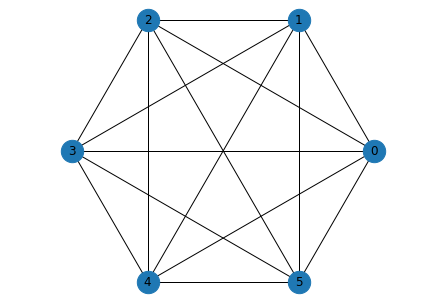

In [ ]:
make_regular_graph(n=6, k=5)

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [ ]:
def plain_bfs(G, start):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

In [ ]:
%timeit plain_bfs(lattice, 0)
%timeit reachable_nodes_bfs(lattice, 0)

100000 loops, best of 3: 15.9 µs per loop
100000 loops, best of 3: 18.9 µs per loop


Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

**Solution**: My implementation of Dijkstra's SPA


In [ ]:
def sp_dijkstra_2(G, source):
    dist = {source: 0}
    next_unvisited = {source}
    while next_unvisited:
        unvisited = next_unvisited
        next_unvisited = set()

        for node in unvisited:
            new_dist = dist[node] + 1

            neighbors = set(G[node]).difference(dist)
            for n in neighbors:
                dist[n] = new_dist
                next_unvisited.add(n)

    return dist

Testing my implementation of Dijkstra's SPA

In [ ]:
# Dijkstra's shortest path algorithm (SPA). 
# NetworkX implementation:
spa_nx = nx.dijkstra_predecessor_and_distance(lattice, 0)[1]
# This book's implementation:
spa_1 = shortest_path_dijkstra(lattice, 0)
# My implementation:
spa_2 = sp_dijkstra_2(lattice, 0)

assert spa_nx == spa_1
assert spa_nx == spa_2
assert spa_1 == spa_2
print("Success!")

Success!


In [ ]:
%timeit shortest_path_dijkstra(lattice, 0)
%timeit sp_dijkstra_2(lattice, 0)

100000 loops, best of 3: 19.8 µs per loop
10000 loops, best of 3: 19.1 µs per loop


**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [ ]:
def bfs(G, start):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [start]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in G[curr_node]
                     if c not in visited and c not in queue)
    return visited

**Solution:**

Below are the reasons why I think `bfs` is not optimized:
1. The object `queue` is not of `collections.deque` type but of the `list` type. So its `pop` method may not execute in constant time. The order of growth of this function call alone might be $O(n)$ since `pop` may have to loop through the `list` all the way to the end.
2. The condition `c not in queue` in the list comprehension may not execute in
constant time as well. Since `list`s are not expected to be ordered in a particular way, the most general way of searching through a `list` object is by linear search which has an worst-case order of $O(n)$.
3. The list comprehension within the `while` construct may be redundant.

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [ ]:
# Solution goes here